In [1]:
%matplotlib inline
import numpy as np
import matplotlib
from matplotlib import pyplot
font = {'size'   : 18}
matplotlib.rc('font', **font)

import scipy.interpolate
import scipy.optimize

# **Data Fitting Exercise**
## **Motivation**

As we have discussed in the data analysis and fitting lectures, the typical way to fit incoherent scatter radar data involves fitting a forward model to the measured lag products, which are estimated from the measured voltage samples received by the radar. To give you a better understanding of the fitting process, we are going to work through fitting a non-linear spectral model to some synthetic data. In particular, we are going to fit a Lorentzian model to some synthetic data.

In the D region the plasma becomes highly collisional with the neutral atmosphere. Here, the frequency extent, or spectral width, of the incoherent scatter power spectrum decreases significantly. For example:


<div>
<img src="pfisr_dregion_spectra.png" width="600">
</div>

([Adapted from Figure 2 of Nicolls et al., 2010](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2010JD014042))

where the x-axis on these plots is frequency in Hz. Notice how the spectral width rapidly narrows below 85 km altitude in the plots. For comparison, note that in the E and F region, the spectral widths of the incoherent scatter is ~1 to ~10s of kHz.

## **The Lorentzian model**

The forward model for Lorentzian incoherent scatter is given by:

$$ L(f) = \frac{\gamma P_r}{\pi \left[ \left(f-f_D\right)^2 + \gamma^2\right]} $$

where $f$ is the frequency in Hz, $f_D$ is the Doppler shift, $\gamma$ is the spectral width, and $P_r$ is the received power.

### **Spectral Width**

For the purposes of this exercise, we will only fit for $\gamma$, but it is interesting to note that with a few assumptions (see Appendix C3 of Nicolls et al., 2010), the spectral width is approximately:

$$ \gamma = \frac{16\pi k_B T}{\lambda^2 m_i \nu_{in}} $$

where $k_B$ is Boltzmann's constant, $T$ is the neutral temperature, $\lambda$ is the radar wavelength, $m_i$ is the mean ion mass, and $\nu_{in}$ is the ion neutral collision frequency. Unsurprisingly, the spectral width is related to physical parameters of the atmosphere!

# **The signal model**

Now we will define a Python function for the signal model:

In [2]:
def lorentzian(f,fd,pr,gamma):
    numerator = gamma * pr
    denominator = np.pi * ((f-fd)**2 + gamma**2)
    
    return numerator / denominator

# **Synthetic Data**
And then we will generate some synthetic data and plot it:

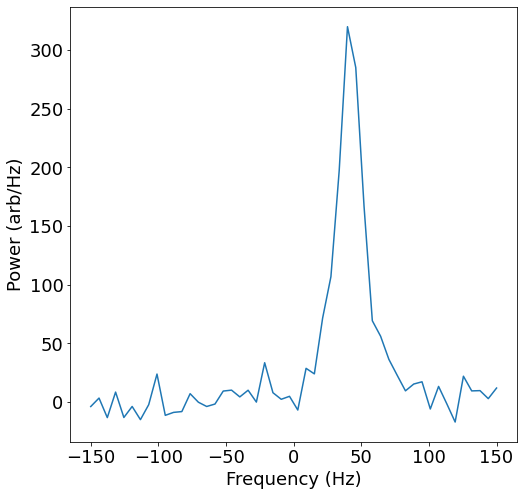

In [3]:
num_frequencies = 50
gamma_true = 10
fd_true = 42   # <-- CHANGE ME ON THE BONUS EXERCISE
pr_true = 1e4

NOISE_POWER = pr_true / 100  # <-- CHANGE ME ON EXERCISE 2 and BONUS

# ideal model of the spectrum
frequencies = np.linspace(-150,150,num=num_frequencies)
spectrum = lorentzian(frequencies,fd_true,pr_true,gamma_true)

# "noise" model
# set the random seed; get the same results each time we generate
# the noise so that we can compare results with each other!
seed = sum([ord(x) for x in 'isrschool'])
np.random.seed(seed)
sigma = np.sqrt(NOISE_POWER)
noise = sigma * np.random.randn(frequencies.size)  # assume gaussian noise

data = spectrum + noise

fig = pyplot.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(frequencies, data);
ax.set_xlabel("Frequency (Hz)");
ax.set_ylabel("Power (arb/Hz)");

## **Fitting the Synthetic Data**

Now, we will use non-linear least-squares to fit the synthetic data with the model.

Fitted gamma: 9.49e+00 +/- 3.67e-01 -- True gamma: 1.00e+01
Fitted fd: 4.18e+01 +/- 2.53e-01 -- True fd: 4.20e+01
Fitted pr: 1.01e+04 +/- 2.72e+02 -- True pr: 1.00e+04
Reduced chi-squared: 1.16


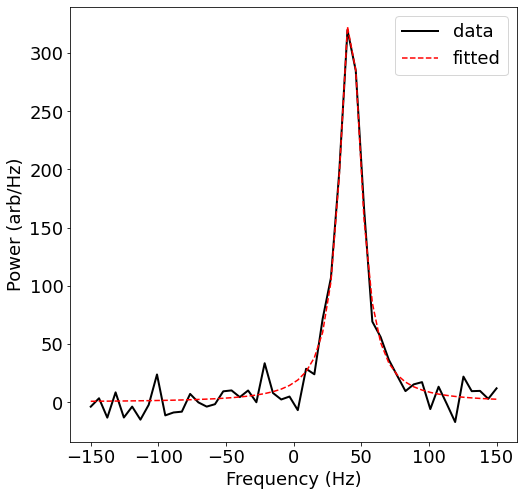

In [4]:
def fit_fun(params,freqs,data,errs):
    # these are the parameters the fitter is changing
    gamma,fd,pr = params
    
    # run the model
    model = lorentzian(frequencies,fd,pr,gamma)
    
    # calculate the "normalize errors"
    normalized_errors = (data - model)/errs
    
    return normalized_errors

###################
# Fitting Procedure
###################
# initial guess: (gamma, fd, pr)
INITIAL_GUESS = (5,0,1e4) # <--- CHANGE ME

measurement_errors = sigma * np.ones(frequencies.size)

# Run the fitter
p = scipy.optimize.leastsq(fit_fun, INITIAL_GUESS, args=(frequencies,data,measurement_errors),full_output=1,factor=100,epsfcn=1.0e-5)

# parse output
fitted_params = p[0]
covariance_of_fit = p[1]

fitted_gamma = fitted_params[0]
fitted_fd = fitted_params[1]
fitted_pr = fitted_params[2]

err_gamma = np.sqrt(covariance_of_fit[0,0])
err_fd = np.sqrt(covariance_of_fit[1,1])
err_pr = np.sqrt(covariance_of_fit[2,2])

# model using best-fit parameters
best_fit_model = lorentzian(frequencies,fitted_fd,fitted_pr,fitted_gamma)

#chi-squared
reduced_chi_squared = np.sum(((data-best_fit_model)/measurement_errors)**2)/(num_frequencies - 3 + 1)

print('Fitted gamma: %0.2e +/- %0.2e -- True gamma: %0.2e' % (fitted_gamma,err_gamma,gamma_true))
print('Fitted fd: %0.2e +/- %0.2e -- True fd: %0.2e' % (fitted_fd,err_fd,fd_true))
print('Fitted pr: %0.2e +/- %0.2e -- True pr: %0.2e' % (fitted_pr,err_pr,pr_true))
print('Reduced chi-squared: %0.2f' % (reduced_chi_squared))
# plot results
fig = pyplot.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(frequencies, data,'k',lw=2,label='data');
ax.plot(frequencies, best_fit_model,'--r',label='fitted');
ax.set_xlabel("Frequency (Hz)");
ax.set_ylabel("Power (arb/Hz)");
ax.legend();

# **Exercises**

**1.** Try changing the "INITIAL_GUESS" to some different values. For example, what if we start with a large spectral width ($\gamma$) INITIAL_GUESS=(100,0,1e4)? Does the fit always work?

**2. a)** Increase the "NOISE_POWER". Set NOISE_POWER = pr/10. Set INITIAL_GUESS=(5,0,1e4). Does the fit still work? How about for INITIAL_GUESS = INITIAL_GUESS = (5,-100,1e4), can you explain what is happening here? What happens to the reduced chi-squared?

**2. b)** Increase the "NOISE_POWER" again. Set NOISE_POWER = pr. Set INITIAL_GUESS=(5,0,1e4). Notice that this now also fails.

## **Bonus**
**3.** Can you find a more robust initial guess? Set NOISE_POWER = pr. Now, try to find an initial guess that works such that you don't have to change it. To do this, set the initial guess and then see if the fitting works properly after you adjust the Doppler shift (changing the "fd_true" variable)

